In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
file_path = '/content/drive/MyDrive/Scom/admin2.csv'
df = pd.read_csv(file_path)


In [28]:
# Encode labels
label_encoder = LabelEncoder()
df['labels'] = label_encoder.fit_transform(df['label'])

# Split the data into train and test sets (80:20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [29]:
# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_encoder.classes_))

# Tokenize the data
train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, return_tensors='pt')


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Create datasets
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_df['labels'].values)
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(test_df['labels'].values)
)


In [31]:
# Define batch size
batch_size = 8

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [32]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [34]:
from transformers import AdamW
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
optimizer = AdamW(model.parameters(), lr=1e-5)


In [35]:
# Define training parameters
num_epochs = 5
optimizer = AdamW(model.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)

    average_train_loss = total_train_loss / len(train_loader)
    accuracy_train = correct_train / total_train

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        total_val_loss = 0

        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct_val += (predictions == labels).sum().item()
            total_val += labels.size(0)

        average_val_loss = total_val_loss / len(test_loader)
        accuracy_val = correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Training Loss: {average_train_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%')
        print(f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {accuracy_val * 100:.2f}%')
        print()

# Evaluate on test set
model.eval()
with torch.no_grad():
    correct_test = 0
    total_test = 0
    total_test_loss = 0

    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_test_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_test += (predictions == labels).sum().item()
        total_test += labels.size(0)

    average_test_loss = total_test_loss / len(test_loader)
    accuracy_test = correct_test / total_test

print(f'Final Training Loss: {average_train_loss:.4f}, Training Accuracy: {accuracy_train * 100:.2f}%')
print(f'Final Test Loss: {average_test_loss:.4f}, Test Accuracy: {accuracy_test * 100:.2f}%')

Epoch 1/5
Training Loss: 0.5570, Training Accuracy: 79.53%
Validation Loss: 0.4468, Validation Accuracy: 84.09%

Epoch 2/5
Training Loss: 0.3816, Training Accuracy: 86.62%
Validation Loss: 0.4227, Validation Accuracy: 86.19%

Epoch 3/5
Training Loss: 0.2690, Training Accuracy: 91.28%
Validation Loss: 0.4238, Validation Accuracy: 86.81%

Epoch 4/5
Training Loss: 0.1863, Training Accuracy: 94.51%
Validation Loss: 0.4417, Validation Accuracy: 86.68%

Epoch 5/5
Training Loss: 0.1460, Training Accuracy: 95.81%
Validation Loss: 0.4392, Validation Accuracy: 86.56%

Final Training Loss: 0.1460, Training Accuracy: 95.81%
Final Test Loss: 0.4392, Test Accuracy: 86.56%


In [37]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Evaluate on test set
model.eval()
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average=None)

# Print precision, recall, and F1 score for each class
for label_idx in range(len(precision)):
    print(f'Label {label_idx + 1}:')
    print(f'Precision: {precision[label_idx]:.4f}, Recall: {recall[label_idx]:.4f}, F1 Score: {f1[label_idx]:.4f}')
    print()

Label 1:
Precision: 0.7553, Recall: 0.7634, F1 Score: 0.7594

Label 2:
Precision: 0.9245, Recall: 0.9333, F1 Score: 0.9289

Label 3:
Precision: 0.9130, Recall: 0.8358, F1 Score: 0.8727

Label 4:
Precision: 0.8634, Recall: 0.9159, F1 Score: 0.8889



In [60]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Evaluate on test set
model.eval()
all_test_predictions = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_test_predictions.extend(predictions.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_test_labels, all_test_predictions, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')



Precision: 0.8668, Recall: 0.8656, F1 Score: 0.8655


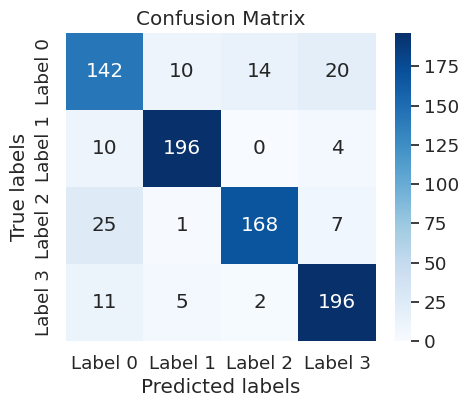

In [61]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_predictions)

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(5, 4))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Define your labels based on your problem
labels = ['Label 0','Label 1', 'Label 2', 'Label 3']  # Update with your actual labels

# Plot confusion matrix
plot_confusion_matrix(conf_matrix, labels)


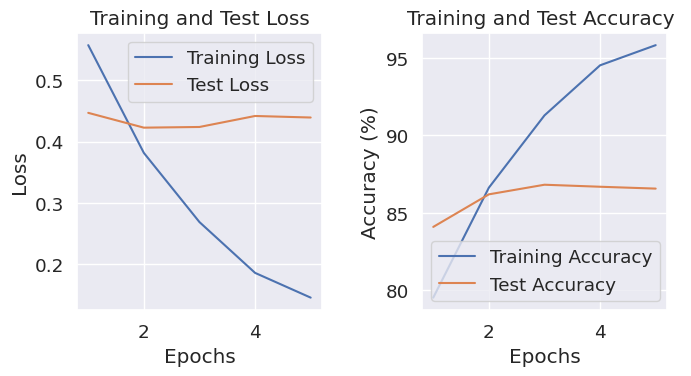

In [58]:
import matplotlib.pyplot as plt

# Manually create arrays based on the provided information
train_losses = [0.5570, 0.3816, 0.2690, 0.1863, 0.1460]  # Update with your actual training losses for each epoch
train_accuracies = [79.53, 86.62, 91.28, 94.51, 95.81]  # Update with your actual training accuracies for each epoch

test_losses = [0.4468, 0.4227, 0.4238, 0.4417, 0.4392]  # Update with your actual test losses for each epoch
test_accuracies = [84.09, 86.19, 86.81, 86.68, 86.56]  # Update with your actual test accuracies for each epoch

# Plotting training and test loss
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), train_losses, label='Training Loss')
plt.plot(range(1, 6), test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 6), test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
